In [229]:
#importing the required stuff
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import *
from qiskit_finance import QiskitFinanceError
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import csv
import yfinance as yf
import pandas_datareader.data as web
import scipy.optimize as optimization

In [230]:
%matplotlib inline

In [231]:
#MPT CODE to benchmark

In [232]:
NUM_TRADING_DAYS = 252 #252*5 cosnidered previously
NUM_PORTFOLIOS = 10000
stocks = ["JPM", "GS", "MSFT", "AAPL", "WMT", "MCD"]

In [233]:
start_date = '2011-01-01' # YY/MM/DD
end_date = '2015-12-31'   # YY/MM/DD

In [234]:
def download_data():
    stocks_data = yf.download(stocks, start = '2011-1-1', end = '2015-12-31')['Adj Close']
    # stocks_data.head()
    return pd.DataFrame(stocks_data)

In [235]:
def show_data(data):
    data.plot(figsize=(8, 5))
    plt.show()

# show_data(data)

In [236]:
def calculate_return(data):
    log_return = np.log(data / data.shift(1))
    return log_return[1:]

In [237]:
def show_statistics(returns):
    print(returns.mean() * NUM_TRADING_DAYS)
    print(returns.cov() * NUM_TRADING_DAYS)

In [238]:
def show_mean_variance(returns, weights):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
    print('Expected portfolio mean: ', portfolio_return)
    print('Expected portfolio volatility: ', portfolio_volatility)
    print("sharpe ratio of a portfolio is ", portfolio_return/portfolio_volatility)

In [239]:
def show_portfolios(returns, volatilities):
    plt.figure(figsize=(8, 5))
    plt.scatter(volatilities, returns, c=returns / volatilities, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()

In [240]:
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

In [241]:
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    for _ in range(NUM_PORTFOLIOS):
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)
        portfolio_means.append(np.sum(returns.mean() * w) * NUM_TRADING_DAYS)
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov() * NUM_TRADING_DAYS, w))))

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

In [242]:
def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))

    return np.array([portfolio_return, portfolio_volatility, portfolio_return / portfolio_volatility])


In [243]:
def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]

In [244]:
def optimize_portfolio(weights, returns):
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((0, 1) for _ in range(len(stocks)))
    return optimization.minimize(fun=min_function_sharpe, x0=weights[0], args=returns, method='SLSQP',
                                 bounds=bounds, constraints=constraints)

In [245]:
def print_optimal_portfolio(optimum, returns):
    print('Optimal Portfolio: ', optimum['x'].round(3))
    print('Expected return, volatility and sharpe ratio: ', statistics(optimum['x'].round(3), returns))

In [246]:
def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(8, 5))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'g*', markersize=20.0)
    plt.show()


In [247]:
ret = np.sum(log_return.mean() * my_weights) * 252 # returns of a portfolio after optimum weight allocation
vol = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*252,my_weights))) # risk of a portfolio after optimum weight allocation
sharpe_ratio = ret/vol # sharpe ratio of a portfolio after optimum weight allocation
print("sharpe ratio of your porrtfolio after optimization is ", sharpe_ratio)

risk_ret_dict_of_quantum = {
    'returns' : ret*100,
    'risk' : vol*100, 
    'sharpe_ratio' : sharpe_ratio 
}

sharpe ratio of your porrtfolio after optimization is  0.7638326696440144


[*********************100%***********************]  6 of 6 completed


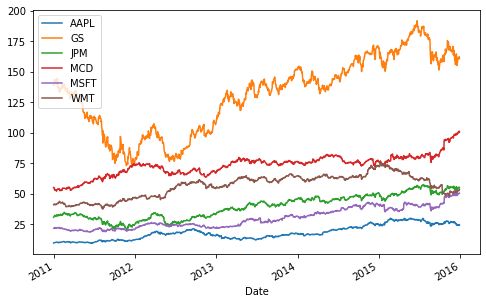

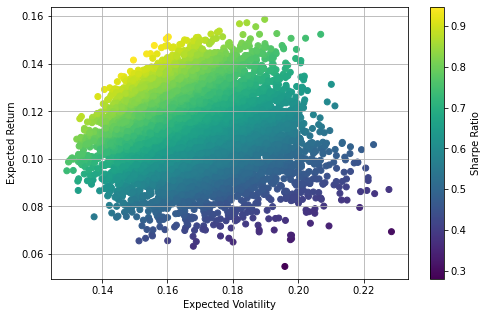

Optimal Portfolio:  [0.229 0.    0.    0.532 0.239 0.   ]
Expected return, volatility and sharpe ratio:  [0.14667675 0.15025056 0.97621438]


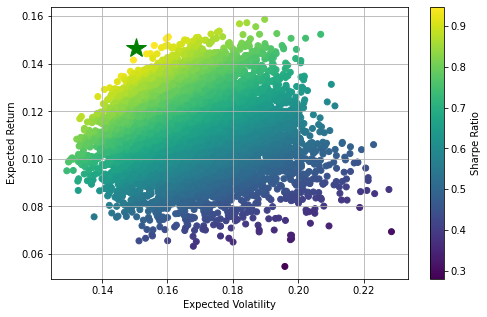

In [248]:
if __name__ == '__main__':
    # print(download_data())
    dataset = download_data()
    show_data(dataset)
    log_daily_returns = calculate_return(dataset)
    # show_statistics(log_daily_returns)
    # show_mean_variance(log_daily_returns, [0.1, 0.2, 0.3, 0.2, 0.1, 0.1])
    pweights, means, risks = generate_portfolios(log_daily_returns)
    show_portfolios(means, risks)
    optimum = optimize_portfolio(pweights, log_daily_returns)
    print_optimal_portfolio(optimum, log_daily_returns)
    show_optimal_portfolio(optimum, log_daily_returns, means, risks)

In [249]:
risk_ret_dict_of_quantum

{'returns': 12.824251141942234,
 'risk': 16.78934621625833,
 'sharpe_ratio': 0.7638326696440144}

In [250]:
# set number of assets (= number of qubits)
num_assets = 6
seed = 123


start = datetime.datetime(2011, 1, 1)
end = datetime.datetime(2015, 12, 31)

df = web.DataReader(["JPM", "GS", "MSFT", "AAPL", "WMT", "MCD"],'yahoo', start, end)
df.to_csv('/Users/vaidehi/Documents/Poster QCE22/result files/stockdata6_1.csv')
print (df)

# Using data from yahoo finance
# use the name listed for particular company that you wish to add
data = YahooDataProvider(
        tickers=["JPM", "GS", "MSFT", "AAPL", "WMT", "MCD"],
        start=datetime.datetime(2011, 1, 1),
        end=datetime.datetime(2015, 12, 31),
    )

data.run()

mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

Attributes  Adj Close                                               \
Symbols           JPM          GS       MSFT       AAPL        WMT   
Date                                                                 
2010-12-31  30.822546  139.064896  21.863089   9.836143  41.184040   
2011-01-03  31.665415  143.108810  21.917925  10.049908  41.665146   
2011-01-04  32.123703  143.133667  22.004091  10.102359  41.825531   
2011-01-05  32.516525  143.894455  21.933605  10.184996  41.550594   
2011-01-06  32.356487  142.414169  22.575941  10.176762  41.206951   
...               ...         ...        ...        ...        ...   
2015-12-24  55.204582  161.394333  50.051350  24.765888  52.786770   
2015-12-28  55.022217  160.642456  50.303089  24.488495  52.717354   
2015-12-29  55.594166  162.331909  50.842529  24.928654  53.463627   
2015-12-30  55.196281  160.987427  50.626747  24.603119  53.524384   
2015-12-31  54.732105  159.413040  49.880531  24.130857  53.194614   

Attributes         

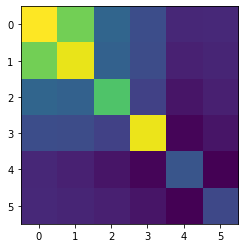

In [251]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()


In [252]:
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio optimization

Minimize
 obj: - 0.000607987172 x_0 - 0.000256621883 x_1 - 0.000777465657 x_2
      - 0.000870573833 x_3 - 0.000260393804 x_4 - 0.000525637836 x_5 + [
      0.000288684196 x_0^2 + 0.000469919066 x_0*x_1 + 0.000238289080 x_0*x_2
      + 0.000191079387 x_0*x_3 + 0.000128683272 x_0*x_4 + 0.000131570938 x_0*x_5
      + 0.000280137973 x_1^2 + 0.000230287039 x_1*x_2 + 0.000190826726 x_1*x_3
      + 0.000119865678 x_1*x_4 + 0.000124718741 x_1*x_5 + 0.000218813304 x_2^2
      + 0.000170862102 x_2*x_3 + 0.000102022369 x_2*x_4 + 0.000116443911 x_2*x_5
      + 0.000281509439 x_3^2 + 0.000080508847 x_3*x_4 + 0.000101951642 x_3*x_5
      + 0.000103132400 x_4^2 + 0.000072714676 x_4*x_5 + 0.000091369398 x_5^2 ]/2
Subject To
 c0: x_0 + x_1 + x_2 + x_3 + x_4 + x_5 = 3

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1
 0 <= x_5 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4 x_5
En

In [253]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result,fname):
    
    f = open(fname, 'w')
    header = ['SELECTION', 'VALUE', 'PROBABLITY']
    writer = csv.writer(f)
    writer.writerow(header)
    
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        row = [x, value, probability]
        writer.writerow(row)
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))
    f.close()

In [254]:
%%time

#classical reference solution
#provide fname ='complete address/location of your .csv file'


exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)
fname = '/Users/vaidehi/Documents/Poster QCE22/result files/nes6_1.csv' #change the location and nsame of .csv file

print_result(result,fname)

Optimal: selection [0. 0. 1. 1. 0. 1.], value -0.0017

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 1 1 0 1]	-0.0017		1.0000
[1 1 1 1 1 1]	9.0451		0.0000
[0 1 1 1 1 0]	1.0039		0.0000
[0 0 1 1 1 0]	-0.0014		0.0000
[1 1 0 1 1 0]	1.0042		0.0000
[0 1 0 1 1 0]	-0.0009		0.0000
[1 0 0 1 1 0]	-0.0012		0.0000
[0 0 0 1 1 0]	1.0043		0.0000
[1 1 1 0 1 0]	1.0044		0.0000
[0 1 1 0 1 0]	-0.0008		0.0000
[1 0 1 0 1 0]	-0.0011		0.0000
[0 0 1 0 1 0]	1.0043		0.0000
[1 1 0 0 1 0]	-0.0004		0.0000
[0 1 0 0 1 0]	1.0049		0.0000
[1 0 0 0 1 0]	1.0046		0.0000
[0 0 0 0 1 0]	4.0205		0.0000
[1 1 1 1 0 0]	1.0039		0.0000
[0 1 1 1 0 0]	-0.0012		0.0000
[1 0 1 1 0 0]	-0.0016		0.0000
[0 0 1 1 0 0]	1.0039		0.0000
[1 1 0 1 0 0]	-0.0009		0.0000
[0 1 0 1 0 0]	1.0044		0.0000
[1 0 0 1 0 0]	1.0041		0.0000
[0 0 0 1 0 0]	4.0199		0.0000
[1 1 1 0 0 0]	-0.0008		0.0000
[0 1 1 0 0 0]	1.0045		0.0000
[1 0 1 0 0 0]	1.0042		0.0000
[0 0 1 0 0 0]	4.02

        SELECTION     VALUE  PROBABLITY
0   [0 0 1 1 0 1] -0.001683         1.0
18  [1 0 1 1 0 0] -0.001561         0.0
54  [1 0 0 1 0 1] -0.001461         0.0
3   [0 0 1 1 1 0] -0.001430         0.0
58  [1 0 1 0 0 1] -0.001369         0.0
40  [0 0 0 1 1 1] -0.001291         0.0
17  [0 1 1 1 0 0] -0.001218         0.0
44  [0 0 1 0 1 1] -0.001211         0.0
6   [1 0 0 1 1 0] -0.001202         0.0
53  [0 1 0 1 0 1] -0.001118         0.0
10  [1 0 1 0 1 0] -0.001106         0.0
57  [0 1 1 0 0 1] -0.001029         0.0
47  [1 0 0 0 1 1] -0.000986         0.0
20  [1 1 0 1 0 0] -0.000884         0.0
5   [0 1 0 1 1 0] -0.000860         0.0
24  [1 1 1 0 0 0] -0.000779         0.0
9   [0 1 1 0 1 0] -0.000767         0.0
60  [1 1 0 0 0 1] -0.000697         0.0
46  [0 1 0 0 1 1] -0.000647         0.0
12  [1 1 0 0 1 0] -0.000430         0.0


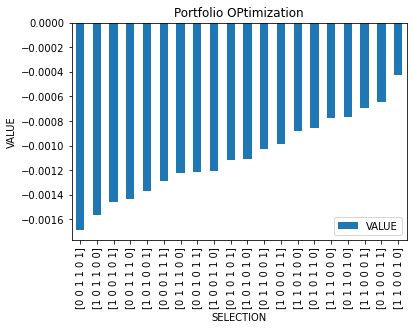

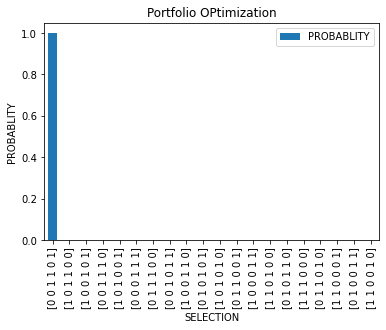

In [255]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/Users/vaidehi/Documents/Poster QCE22/result files/nes6_1.csv')
df = df[df['VALUE'] == df.groupby('SELECTION')['VALUE'].transform('min')]

df = df.sort_values('VALUE').drop_duplicates('SELECTION')
df1 = df[df['VALUE'] < 0]
print(df1)

df1.to_csv('/Users/vaidehi/Documents/Poster QCE22/result files/nes6_1_neg.csv')


df1. plot(kind="bar", x = 'SELECTION', y = 'VALUE')
plt.title('Portfolio OPtimization')
plt.ylabel('VALUE')
#plt.figure(figsize=(10,5))
plt.show()

df1. plot(kind="bar", x = 'SELECTION', y = 'PROBABLITY')
plt.ylabel('PROBABLITY')
plt.title('Portfolio OPtimization')
#plt.figure(figsize=(10,5))
plt.show()

In [256]:
%%time

# VQE solution
#provide fname ='complete address/location of your .csv file'


from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

fname = '/Users/vaidehi/Documents/Poster QCE22/result files/vqe6_1.csv' #change the location and name of .csv file
print_result(result, fname)


Optimal: selection [1. 0. 1. 0. 0. 1.], value -0.0014

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 1 0 1 1]	-0.0012		0.7036
[1 0 0 0 1 1]	-0.0010		0.1485
[1 1 1 0 0 0]	-0.0008		0.1084
[1 0 1 0 1 0]	-0.0011		0.0223
[1 1 0 0 0 1]	-0.0007		0.0110
[0 1 1 0 0 1]	-0.0010		0.0060
[0 1 1 1 0 0]	-0.0012		0.0000
[1 1 1 0 1 0]	1.0044		0.0000
[1 1 0 1 0 0]	-0.0009		0.0000
[0 0 0 0 1 0]	4.0205		0.0000
[1 1 0 0 0 0]	1.0048		0.0000
[1 0 0 0 1 0]	1.0046		0.0000
[1 1 1 1 0 0]	1.0039		0.0000
[1 0 1 0 0 1]	-0.0014		0.0000
[0 0 0 0 1 1]	1.0045		0.0000
[1 1 0 0 1 0]	-0.0004		0.0000
[0 1 1 0 1 1]	1.0041		0.0000
[1 1 0 1 0 1]	1.0040		0.0000
[1 1 1 0 0 1]	1.0041		0.0000
[1 0 0 1 1 1]	1.0036		0.0000
[1 0 1 0 0 0]	1.0042		0.0000
[1 0 0 0 0 1]	1.0043		0.0000
[0 1 0 1 0 1]	-0.0011		0.0000
[1 1 1 1 0 1]	4.0192		0.0000
[1 0 0 1 1 0]	-0.0012		0.0000
[1 0 1 0 1 1]	1.0037		0.0000
[0 1 0 1 0 0]	1.0044		0.0000
[0 1 1 1 0 1]	1.0

        SELECTION     VALUE    PROBABLITY
59  [0 0 1 1 0 1] -0.001683  5.205626e-12
62  [1 0 1 1 0 0] -0.001561  2.110549e-12
60  [1 0 0 1 0 1] -0.001461  2.261552e-12
40  [0 0 1 1 1 0] -0.001430  5.558288e-08
13  [1 0 1 0 0 1] -0.001369  2.429483e-06
28  [0 0 0 1 1 1] -0.001291  4.399800e-07
6   [0 1 1 1 0 0] -0.001218  2.733099e-05
0   [0 0 1 0 1 1] -0.001211  7.036199e-01
24  [1 0 0 1 1 0] -0.001202  5.013731e-07
22  [0 1 0 1 0 1] -0.001118  5.287637e-07
3   [1 0 1 0 1 0] -0.001106  2.233355e-02
5   [0 1 1 0 0 1] -0.001029  5.980936e-03
1   [1 0 0 0 1 1] -0.000986  1.485250e-01
8   [1 1 0 1 0 0] -0.000884  1.701955e-05
49  [0 1 0 1 1 0] -0.000860  7.099917e-10
2   [1 1 1 0 0 0] -0.000779  1.084122e-01
50  [0 1 1 0 1 0] -0.000767  4.837556e-10
4   [1 1 0 0 0 1] -0.000697  1.101359e-02
44  [0 1 0 0 1 1] -0.000647  9.611527e-09
15  [1 1 0 0 1 0] -0.000430  1.692027e-06


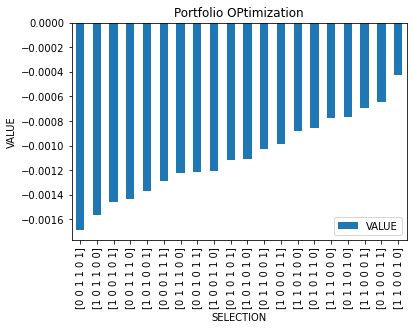

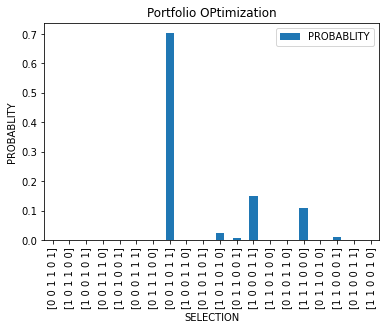

In [257]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/Users/vaidehi/Documents/Poster QCE22/result files/vqe6_1.csv')
df = df[df['VALUE'] == df.groupby('SELECTION')['VALUE'].transform('min')]

df = df.sort_values('VALUE').drop_duplicates('SELECTION')
df1 = df[df['VALUE'] < 0]
print(df1)

df1.to_csv('/Users/vaidehi/Documents/Poster QCE22/result files/vqe6_1_neg.csv')


df1. plot(kind="bar", x = 'SELECTION', y = 'VALUE')
plt.title('Portfolio OPtimization')
plt.ylabel('VALUE')
#plt.figure(figsize=(10,5))
plt.show()

df1. plot(kind="bar", x = 'SELECTION', y = 'PROBABLITY')
plt.ylabel('PROBABLITY')
plt.title('Portfolio OPtimization')
#plt.figure(figsize=(10,5))
plt.show()

In [258]:
%%time

# QAOA solution
#provide fname ='complete address/location of your .csv file'


algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

fname = '/Users/vaidehi/Documents/Poster QCE22/result files/qaoa6_1.csv' #change the location and name of .csv file
print_result(result, fname)


Optimal: selection [0. 0. 1. 1. 0. 1.], value -0.0017

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 1 1 0 1]	-0.0017		0.0471
[1 0 1 1 0 0]	-0.0016		0.0471
[0 0 1 1 1 0]	-0.0014		0.0471
[1 0 0 1 0 1]	-0.0015		0.0471
[1 0 1 0 0 1]	-0.0014		0.0471
[0 0 0 1 1 1]	-0.0013		0.0471
[1 0 0 1 1 0]	-0.0012		0.0471
[0 0 1 0 1 1]	-0.0012		0.0471
[0 1 1 1 0 0]	-0.0012		0.0471
[0 1 0 1 0 1]	-0.0011		0.0471
[1 0 1 0 1 0]	-0.0011		0.0471
[0 1 1 0 0 1]	-0.0010		0.0471
[1 0 0 0 1 1]	-0.0010		0.0470
[0 1 0 1 1 0]	-0.0009		0.0470
[1 1 0 1 0 0]	-0.0009		0.0470
[0 1 1 0 1 0]	-0.0008		0.0470
[1 1 0 0 0 1]	-0.0007		0.0470
[1 1 1 0 0 0]	-0.0008		0.0470
[0 1 0 0 1 1]	-0.0006		0.0470
[1 1 0 0 1 0]	-0.0004		0.0470
[1 0 1 1 0 1]	1.0033		0.0018
[1 0 1 1 1 0]	1.0036		0.0018
[0 1 1 1 0 1]	1.0036		0.0018
[0 0 1 1 1 1]	1.0034		0.0018
[1 1 1 1 0 0]	1.0039		0.0018
[1 0 0 1 1 1]	1.0036		0.0018
[1 1 0 1 0 1]	1.0040		0.0018
[0 1 1 1 

        SELECTION     VALUE  PROBABLITY
0   [0 0 1 1 0 1] -0.001683    0.047141
1   [1 0 1 1 0 0] -0.001561    0.047111
3   [1 0 0 1 0 1] -0.001461    0.047110
2   [0 0 1 1 1 0] -0.001430    0.047110
4   [1 0 1 0 0 1] -0.001369    0.047099
5   [0 0 0 1 1 1] -0.001291    0.047084
8   [0 1 1 1 0 0] -0.001218    0.047073
7   [0 0 1 0 1 1] -0.001211    0.047075
6   [1 0 0 1 1 0] -0.001202    0.047079
9   [0 1 0 1 0 1] -0.001118    0.047069
10  [1 0 1 0 1 0] -0.001106    0.047068
11  [0 1 1 0 0 1] -0.001029    0.047059
12  [1 0 0 0 1 1] -0.000986    0.047046
14  [1 1 0 1 0 0] -0.000884    0.047037
13  [0 1 0 1 1 0] -0.000860    0.047039
17  [1 1 1 0 0 0] -0.000779    0.047024
15  [0 1 1 0 1 0] -0.000767    0.047028
16  [1 1 0 0 0 1] -0.000697    0.047024
18  [0 1 0 0 1 1] -0.000647    0.047004
19  [1 1 0 0 1 0] -0.000430    0.046994


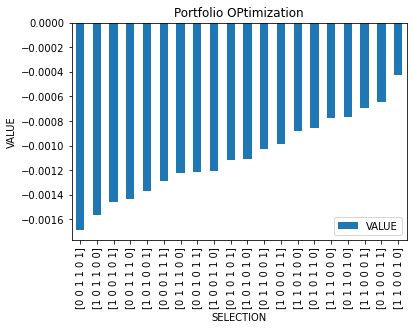

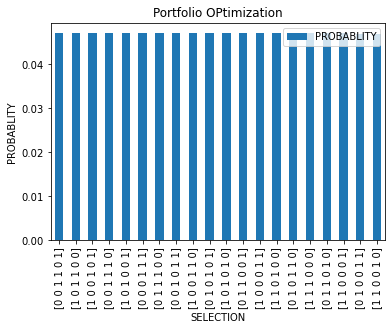

In [259]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/Users/vaidehi/Documents/Poster QCE22/result files/qaoa6_1.csv')
df = df[df['VALUE'] == df.groupby('SELECTION')['VALUE'].transform('min')]

df = df.sort_values('VALUE').drop_duplicates('SELECTION')
df1 = df[df['VALUE'] < 0]
print(df1)

df1.to_csv('/Users/vaidehi/Documents/Poster QCE22/result files/qaoa6_1_neg.csv')


df1. plot(kind="bar", x = 'SELECTION', y = 'VALUE')
plt.title('Portfolio OPtimization')
plt.ylabel('VALUE')
#plt.figure(figsize=(10,5))
plt.show()

df1. plot(kind="bar", x = 'SELECTION', y = 'PROBABLITY')
plt.ylabel('PROBABLITY')
plt.title('Portfolio OPtimization')
#plt.figure(figsize=(10,5))
plt.show()

In [260]:
#weight allocation part after asset selection using quantum

selected_assets = [0, 0, 1, 1, 0, 1]
assets = ["JPM", "GS", "MSFT", "AAPL", "WMT", "MCD"]

selected_bitstring = [i for i, e in enumerate(selected_assets) if e == 1]
# print(selected_bitstring)
my_assets = [assets[i] for i in selected_bitstring]
print("your lucky assets are ",my_assets)

your lucky assets are  ['MSFT', 'AAPL', 'MCD']


In [261]:
import yfinance as yf
import numpy as np
selected_stocks_data = yf.download(my_assets, start = '2011-1-1', end = '2015-12-31')['Close']
selected_stocks_data.head()

[*********************100%***********************]  3 of 3 completed


,AAPL,MCD,MSFT
Date,,,
2010-12-31,11.520000,76.760002,27.91
2011-01-03,11.770357,76.599998,27.98
2011-01-04,11.831786,74.309998,28.09
2011-01-05,11.928571,74.660004,28.00
2011-01-06,11.918929,74.209999,28.82


In [262]:
log_return = np.log(selected_stocks_data/selected_stocks_data.shift(1))
log_return.head()

,AAPL,MCD,MSFT
Date,,,
2010-12-31,NaN,NaN,NaN
2011-01-03,0.021500,-0.002087,0.002505
2011-01-04,0.005205,-0.030352,0.003924
2011-01-05,0.008147,0.004699,-0.003209
2011-01-06,-0.000809,-0.006046,0.028865


In [263]:
import numpy as np
weights = np.array(np.random.random(len(my_assets)))

print('normalised weights :')
weights = weights/np.sum(weights)
print(weights)

normalised weights :
[0.48863815 0.1219836  0.38937825]


In [264]:
from scipy.optimize import minimize

def get_ret_vol_sr(weights): 
    weights = np.array(weights)
    ret = np.sum(log_return.mean() * weights) * 250
    vol = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*252,weights)))
    sr = ret/vol 
    return np.array(sr)
    

# minimize negative Sharpe Ratio
def neg_sharpe(weights): 
    return get_ret_vol_sr(weights)*-1

# check allocation sums to 1
def check_sum(weights): 
    return np.sum(weights) - 1

In [265]:
# create constraint variable
cons = ({'type':'eq','fun':check_sum})

In [266]:
# create weight boundaries
bounds = tuple((0, 1) for stocks in range(len(my_assets)))

In [267]:
# initial guess
# init_guess = [0.1 for stocks in range(len(my_assets))]
init_guess = [0.3, 0.5, 0.2]
# tuple((0, 1) for stocks in range(len(my_assets)))


In [268]:
neg_sharpe(weights)

-0.7676685278387632

In [269]:
# from scipy.optimize import minimize
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
opt_results

     fun: -0.7992642959144163
     jac: array([-2.29418278e-04, -2.77832150e-05,  3.07150185e-04])
 message: 'Optimization terminated successfully'
    nfev: 16
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.31453317, 0.41314645, 0.27232038])

In [270]:
my_weights = np.array(opt_results.x)
my_weights = my_weights.tolist()

In [271]:
tot_weights = np.sum(my_weights)
tot_weights

1.0

In [272]:
weights_alloc = dict(zip(my_assets, my_weights))
weights_alloc

{'MSFT': 0.3145331714538622,
 'AAPL': 0.41314644566656306,
 'MCD': 0.27232038287957466}

In [273]:
my_assets

['MSFT', 'AAPL', 'MCD']

In [274]:
ret = np.sum(log_return.mean() * my_weights) * 252 # returns of a portfolio after optimum weight allocation
vol = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*252,my_weights))) # risk of a portfolio after optimum weight allocation
sharpe_ratio = ret/vol # sharpe ratio of a portfolio after optimum weight allocation
print("sharpe ratio of your porrtfolio after optimization is ", sharpe_ratio)

risk_ret_dict_of_quantum = {
    'returns' : ret*100,
    'risk' : vol*100, 
    'sharpe_ratio' : sharpe_ratio 
}

sharpe ratio of your porrtfolio after optimization is  0.7488924020353771


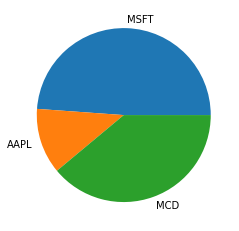

In [275]:
import matplotlib.pyplot as plt
import numpy as np

y = np.array(weights)
mylabels = my_assets

plt.pie(y, labels = mylabels)
plt.show()

In [276]:
risk_ret_dict_of_quantum

{'returns': 12.824251141942234,
 'risk': 17.12429062851732,
 'sharpe_ratio': 0.7488924020353771}